# Import libraries

In [ ]:
#import library
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate, Dropout

from sklearn.model_selection import train_test_split

# sets the execution mode to "eager" mode. Useful for small experimentation. 
# TensorFlow immediately evaluates operations and returns concrete values
# instead of constructing a computation graph to run later in a session. 
# This means that you can run TensorFlow operations and functions imperatively, 
tf.config.run_functions_eagerly(True)

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

We wish to specify the data types of each column in the DataFrame. We create a dictionary that maps each numeric column to the numpy.uint8 data type. This helps the conversion of array to images. 

We set the engine to "c" because it's faster and the data type is simple. We don't need the full python engine.

In [ ]:
img_df = pd.read_csv("images_train.csv")

In [ ]:
img_df_val = pd.read_csv("images_validation.csv")

In [ ]:
img_df.head(2)

,Unnamed: 0,label_group,image,0,1,2,3,4,5,6,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0,249114794,0000a68812bc7e98c42888dfb1c07da0.jpg,143,73,83,150,85,95,153,...,142,194,116,134,191,111,129,193,122,143
1,1,2937985045,00039780dfc94d01db8676fe789ecd05.jpg,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
img_df_val.head(2)

,Unnamed: 0,label_group,image,0,1,2,3,4,5,6,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,11443,3044373336,560a5c3577fb22be2ac82c0e97558158.jpg,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,29516,873493898,dd1f14c7a734ff28b67062ae4f8529c6.jpg,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
# Getting the numeric values for images

X = img_df.iloc[:,3:]
X_rows = img_df.shape[0]

X_val = img_df_val.iloc[:,3:]
X_rows_val = img_df_val.shape[0]

In [ ]:
X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,143,73,83,150,85,95,153,88,98,158,...,142,194,116,134,191,111,129,193,122,143
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
X_val.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
print(f"number of train images: {X_rows}")
print(f"number of validation images: {X_rows_val}")

number of train images: 29603
number of validation images: 4647


# Preprocessing

In [ ]:
# We reshape the images to (64,64,3) numpy arrays
X_ar = X.to_numpy().reshape((X_rows, 64, 64, 3))
X_ar_val = X_val.to_numpy().reshape((X_rows_val, 64, 64, 3))

In [ ]:
# Checking array shape
X_ar[0].shape

(64, 64, 3)

In [ ]:
X_ar_val[0].shape

(64, 64, 3)

Check: are the images loaded properly?

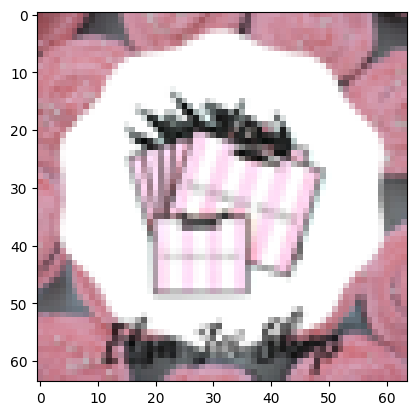

In [ ]:
# Converting the first image to array
X0 = X_ar[0].reshape([64,64,3])
plt.imshow(X0)

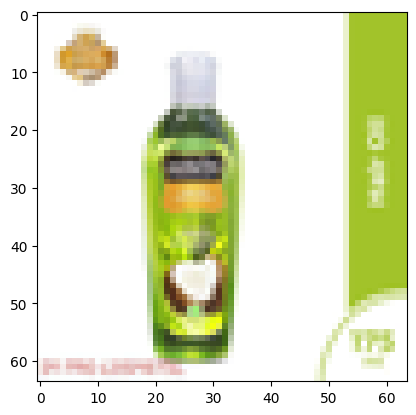

In [ ]:
X0_val = X_ar_val[0].reshape([64,64,3])
plt.imshow(X0_val)

Normalize the image

In [ ]:
X_ar_normalized = X_ar / 255.0
X_ar_val_normalized = X_ar_val / 255.0

# Apply one-hot encoding to labels

In [ ]:
# label pre-processing: convert to group then perform onehot encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 

# Convert labels to integers using LabelEncoder
labels_int = le.fit_transform(img_df['label_group'])

# One-hot encode the labels using to_categorical
y_train = to_categorical(labels_int)

# Print the shape of the one-hot encoded labels
print(y_train.shape)

(29603, 11014)


## Mapping
We need a mapping function that connects the encoded label and the original label in the train dataset.

Otherwise, given an observation of the same group_label, its encoded label will be different from y_train to y_val. 

For instance, let's suppose the group label 993412341234 has the largest value in the dataset. 

In the train dataset: this label will have an encoded label of 11014.

In the validation dataset, this label will have an encoded label of 4000 in the validation dataset, because there are only 4000 unique labels in the validation dataset.

This non-matching error will result in low accuracies.

In [ ]:
# Create a mapping table between integer labels and their original string values
label_mapping = {i: label for i, label in enumerate(le.classes_)}

labels_map = {v: k for k, v in label_mapping.items()}

# Convert the mapping table to a DataFrame
label_mapping_df = pd.DataFrame(list(label_mapping.items()), columns=['Encoded Label', 'Original Label'])

# Print the DataFrame
print(label_mapping_df)

       Encoded Label  Original Label
0                  0          258047
1                  1          297977
2                  2          645628
3                  3          801176
4                  4          887886
...              ...             ...
11009          11009      4292154092
11010          11010      4292520070
11011          11011      4292939171
11012          11012      4293276364
11013          11013      4294197112

[11014 rows x 2 columns]


In [ ]:
# Convert labels to encoded values that is coherent with training labels using mapping
labels_val = img_df_val['label_group'].map(labels_map)

# One-hot encode the labels using to_categorical
y_val = to_categorical(labels_val, num_classes=y_train.shape[1])

# Print the shape of the one-hot encoded labels
print(y_val.shape)

(4647, 11014)


In [ ]:
#Dataset already split from import csv files
X_image_train = X_ar_normalized
X_image_val = X_ar_val_normalized

# Standalone Keras-CNN Model (Images Only)

In [ ]:
input_shape=X_ar_normalized.shape[1:]
X_ar_normalized.shape[1:]

(64, 64, 3)

In [ ]:
# Define the architecture of the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), 
                  activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.25), 
    layers.Dense(64, activation='relu'),
    layers.Dense(y_val.shape[1], activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dropout (Dropout)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 64)                3444800   
                                                        

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_image_train, 
          y_train, 
          epochs=10, 
          batch_size=32, validation_data=(X_image_val, y_val))

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
926/926 [==============================] - 50s 45ms/step - loss: 9.3169 - accuracy: 0.0013 - val_loss: 9.1795 - val_accuracy: 0.0034
Epoch 2/10
926/926 [==============================] - 41s 45ms/step - loss: 8.9412 - accuracy: 0.0111 - val_loss: 8.7559 - val_accuracy: 0.0275
Epoch 3/10
926/926 [==============================] - 41s 44ms/step - loss: 8.1294 - accuracy: 0.0373 - val_loss: 8.4715 - val_accuracy: 0.0603
Epoch 4/10
926/926 [==============================] - 41s 44ms/step - loss: 7.1312 - accuracy: 0.0822 - val_loss: 8.6216 - val_accuracy: 0.1063
Epoch 5/10
926/926 [==============================] - 41s 44ms/step - loss: 6.1196 - accuracy: 0.1396 - val_loss: 9.2118 - val_accuracy: 0.1437
Epoch 6/10
926/926 [==============================] - 41s 45ms/step - loss: 5.2555 - accuracy: 0.2012 - val_loss: 10.1946 - val_accuracy: 0.1769
Epoch 7/10
926/926 [==============================] - 41s 45ms/step - loss: 4.5740 - accuracy: 0.2646 - val_loss: 10.9620 - val_accurac

# Second Keras-CNN Model
What if we add more neurons and add another dropout layer? Would that give us better results?

In [ ]:
# Define the architecture of the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), 
                  activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.25), 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25), 
    layers.Dense(256, activation='relu'),
    layers.Dense(y_val.shape[1], activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 53824)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6889600   
                                                      

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_image_train, 
          y_train, 
          epochs=10, 
          batch_size=32, validation_data=(X_image_val, y_val))

Epoch 1/10
926/926 [==============================] - 49s 53ms/step - loss: 9.2561 - accuracy: 0.0044 - val_loss: 8.8908 - val_accuracy: 0.0194
Epoch 2/10
926/926 [==============================] - 48s 52ms/step - loss: 8.4784 - accuracy: 0.0305 - val_loss: 8.2842 - val_accuracy: 0.0652
Epoch 3/10
926/926 [==============================] - 48s 52ms/step - loss: 7.4036 - accuracy: 0.0829 - val_loss: 7.8290 - val_accuracy: 0.1224
Epoch 4/10
926/926 [==============================] - 48s 52ms/step - loss: 6.3077 - accuracy: 0.1465 - val_loss: 7.6775 - val_accuracy: 0.1844
Epoch 5/10
926/926 [==============================] - 48s 52ms/step - loss: 5.3058 - accuracy: 0.2153 - val_loss: 7.9072 - val_accuracy: 0.2234
Epoch 6/10
926/926 [==============================] - 48s 52ms/step - loss: 4.4560 - accuracy: 0.2936 - val_loss: 8.3291 - val_accuracy: 0.2591
Epoch 7/10
926/926 [==============================] - 49s 53ms/step - loss: 3.7674 - accuracy: 0.3672 - val_loss: 8.4991 - val_accuracy:

Training Accuracy: 042 => 0.54

Validation Accuracy: 0.25 => 0.34

# Grid Search

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the hyperparameters to explore
dense_units = 64
dropout_rate = 0.25

param_grid = {
    'filters': [32, 64],
    'kernel_size': [(2, 2), (3, 3)],
}

# Create a function to build the model with the given hyperparameters
def create_model(filters, kernel_size):
    # Define the architecture of the CNN model
  model = tf.keras.Sequential([
      layers.Conv2D(filters, kernel_size, activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(filters, kernel_size, activation='relu'),
      layers.Dropout(dropout_rate), 
      layers.Flatten(),
      layers.Dense(dense_units, activation='relu'),
      layers.Dropout(dropout_rate), 
      layers.Dense(y_val.shape[1], activation = 'softmax')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
# Create an instance of the KerasClassifier with the function and hyperparameters to explore
model = KerasClassifier(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

<ipython-input-25-326af75e13ea>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [ ]:
# Fit the grid search to the data
grid_result = grid.fit(X_image_train, 
          y_train, 
          epochs=10, 
          batch_size=32, validation_data=(X_image_val, y_val))

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy score: {grid_result.best_score_}")

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Best parameters: {'filters': 32, 'kernel_size': (2, 2)}
Best accuracy score: 0.21112677454948425


# Best Model (1 Dense Layer)

In [ ]:
filters = 32
kernel_size = (2, 2)
dropout_rate = 0.25
dense_units = 64

model = tf.keras.Sequential([
    layers.Conv2D(filters, kernel_size, activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters, kernel_size, activation='relu'),
    layers.Dropout(dropout_rate), 
    layers.Flatten(),
    layers.Dense(dense_units, activation='relu'),
    layers.Dropout(dropout_rate), 
    layers.Dense(y_val.shape[1], activation = 'softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_image_train, 
          y_train, 
          epochs=10, 
          batch_size=32, validation_data=(X_image_val, y_val))

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
926/926 [==============================] - 53s 49ms/step - loss: 9.2867 - accuracy: 0.0025 - val_loss: 8.9926 - val_accuracy: 0.0140
Epoch 2/10
926/926 [==============================] - 44s 48ms/step - loss: 8.6325 - accuracy: 0.0253 - val_loss: 8.3770 - val_accuracy: 0.0618
Epoch 3/10
926/926 [==============================] - 44s 48ms/step - loss: 7.5240 - accuracy: 0.0776 - val_loss: 7.9222 - val_accuracy: 0.1293
Epoch 4/10
926/926 [==============================] - 45s 48ms/step - loss: 6.2646 - accuracy: 0.1471 - val_loss: 7.7731 - val_accuracy: 0.1986
Epoch 5/10
926/926 [==============================] - 44s 48ms/step - loss: 5.1164 - accuracy: 0.2268 - val_loss: 7.9612 - val_accuracy: 0.2442
Epoch 6/10
926/926 [==============================] - 44s 48ms/step - loss: 4.1624 - accuracy: 0.3098 - val_loss: 8.4369 - val_accuracy: 0.2823
Epoch 7/10
926/926 [==============================] - 45s 48ms/step - loss: 3.4674 - accuracy: 0.3842 - val_loss: 9.1921 - val_accuracy:

Kernel Size: (3, 3) => (2, 2)

Training Accuracy: 0.54 => 0.54

Validation Accuracy: 0.34 => 0.36

In [ ]:
# Save the trained model
# model.save('base_model.h5')

In [ ]:
# Import the model
# from keras.models import load_model
# history2 = load_model('base_model.h5')

In [ ]:
# Evaluate the model using the import model
# loss, accuracy = history2.evaluate(X_image_val, y_val)
# print('Test accuracy:', accuracy)